## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [17]:

import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import os

import sys
sys.path.append('waveglow/')
import numpy as np
import torch
import torchaudio

import librosa

from tacotron2.hparams import create_hparams
from tacotron2.model import Tacotron2
from tacotron2.layers import TacotronSTFT, STFT
from tacotron2.audio_processing import griffin_lim
from tacotron2.train import load_model
from tacotron2.text import text_to_sequence
from waveglow.denoiser import Denoiser
import librosa.display

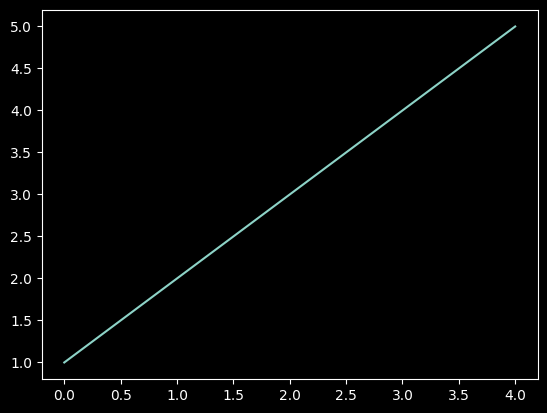

In [18]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.show()
plt.plot([1,2,3,4,5])
plt.show()

#### Setup hparams

In [3]:
hparams = create_hparams()
print(hparams)
hparams["sampling_rate"] = 22050

{'epochs': 10, 'iters_per_checkpoint': 1000, 'seed': 1234, 'dynamic_loss_scaling': True, 'fp16_run': False, 'distributed_run': False, 'dist_backend': 'nccl', 'dist_url': 'tcp://localhost:54321', 'cudnn_enabled': True, 'cudnn_benchmark': False, 'ignore_layers': ['embedding.weight'], 'load_mel_from_disk': False, 'training_files': 'filelists/ljs_audio_text_train_filelist.txt', 'validation_files': 'filelists/ljs_audio_text_val_filelist.txt', 'text_cleaners': ['english_cleaners'], 'max_wav_value': 32768.0, 'sampling_rate': 22050, 'filter_length': 1024, 'hop_length': 256, 'win_length': 1024, 'n_mel_channels': 80, 'mel_fmin': 0.0, 'mel_fmax': 8000.0, 'n_symbols': 148, 'symbols_embedding_dim': 512, 'encoder_kernel_size': 5, 'encoder_n_convolutions': 3, 'encoder_embedding_dim': 512, 'n_frames_per_step': 1, 'decoder_rnn_dim': 1024, 'prenet_dim': 256, 'max_decoder_steps': 1000, 'gate_threshold': 0.5, 'p_attention_dropout': 0.1, 'p_decoder_dropout': 0.1, 'attention_rnn_dim': 1024, 'attention_dim':

#### Load model from checkpoint

In [106]:
checkpoint_path = "tacotron2_statedict.pt"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
#_ = model.cuda().eval().half()
_ = model.cuda()
# also modified train.py line:74

#_ = model.eval()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [107]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
#waveglow.cuda().eval().half()
waveglow.cuda()
# modified denoiser.py line:15
# modified glow.py line:268
# modified glow.py line:298

#waveglow.eval()#.half()

for k in waveglow.convinv:
    k.float()
    
#denoiser = Denoiser(waveglow)

c:\Users\Trevi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'glow.WaveGlow' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\Users\Trevi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\Users\Trevi\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you

#### Prepare text input

In [108]:
text = "Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition."
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()
    #torch.from_numpy(sequence)).long()
print(sequence)

[[53 55 46 51 57 46 51 44  6 11 46 51 11 57 45 42 11 52 51 49 62 11 56 42
  51 56 42 11 60 46 57 45 11 60 45 46 40 45 11 60 42 11 38 55 42 11 38 57
  11 53 55 42 56 42 51 57 11 40 52 51 40 42 55 51 42 41  6 11 41 46 43 43
  42 55 56 11 43 55 52 50 11 50 52 56 57 11 46 43 11 51 52 57 11 43 55 52
  50 11 38 49 49 11 57 45 42 11 38 55 57 56 11 38 51 41 11 40 55 38 43 57
  56 11 55 42 53 55 42 56 42 51 57 42 41 11 46 51 11 57 45 42 11 42 61 45
  46 39 46 57 46 52 51 53 55 46 51 57 46 51 44  6 11 46 51 11 57 45 42 11
  52 51 49 62 11 56 42 51 56 42 11 60 46 57 45 11 60 45 46 40 45 11 60 42
  11 38 55 42 11 38 57 11 53 55 42 56 42 51 57 11 40 52 51 40 42 55 51 42
  41  6 11 41 46 43 43 42 55 56 11 43 55 52 50 11 50 52 56 57 11 46 43 11
  51 52 57 11 43 55 52 50 11 38 49 49 11 57 45 42 11 38 55 57 56 11 38 51
  41 11 40 55 38 43 57 56 11 55 42 53 55 42 56 42 51 57 42 41 11 46 51 11
  57 45 42 11 42 61 45 46 39 46 57 46 52 51  7]]
tensor([[53, 55, 46, 51, 57, 46, 51, 44,  6, 11, 46, 51, 11, 57

In [7]:
text = "This is a test for my presentation!"
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
processed, lengths = processor(text)
print(processed)
print(lengths)

tensor([[31, 19, 20, 30, 11, 20, 30, 11, 12, 11, 31, 16, 30, 31, 11, 17, 26, 29,
         11, 24, 36, 11, 27, 29, 16, 30, 16, 25, 31, 12, 31, 20, 26, 25,  2]])
tensor([35], dtype=torch.int32)


#### Decode text input and plot results

Warning! Reached max decoder steps


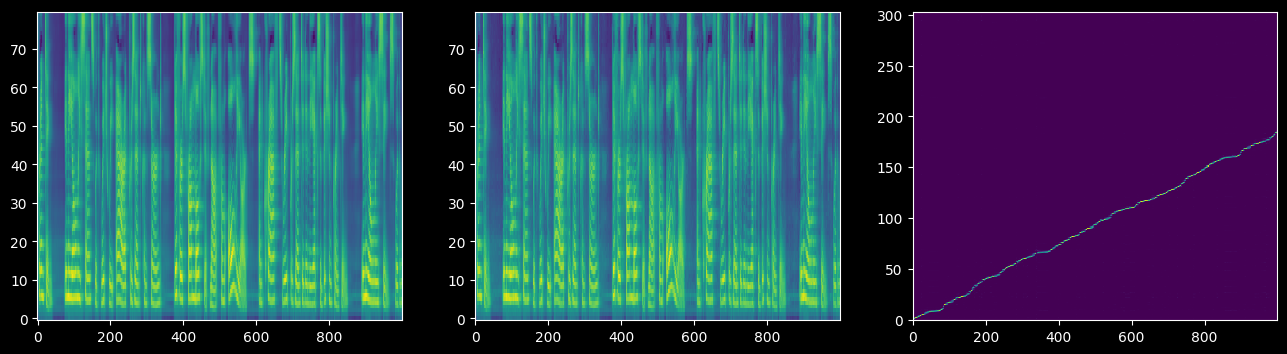

In [109]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [9]:
from tacotron2.utils import load_wav_to_torch
import tacotron2.layers

stft = tacotron2.layers.TacotronSTFT(
            hparams["filter_length"], hparams["hop_length"], hparams["win_length"],
            hparams["n_mel_channels"], hparams["sampling_rate"], hparams["mel_fmin"],
            hparams["mel_fmax"])

def get_mel(filename):
        if not hparams["load_mel_from_disk"]:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(
                    sampling_rate, stft.sampling_rate))
            audio_norm = audio / hparams["max_wav_value"]
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), stft.n_mel_channels))

        return melspec

def get_text(text):
        text_norm = torch.IntTensor(text_to_sequence(text, ['english_cleaners']))
        return text_norm

1024 256


c:\Users\Trevi\Desktop\AI\ProSS\src\ProSS\model\tacotron2\stft.py:68: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
c:\Users\Trevi\Desktop\AI\ProSS\src\ProSS\model\tacotron2\layers.py:50: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


1024 256
tensor(0.4172, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1410, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.7100, device='cuda:0', grad_fn=<AddBackward0>)


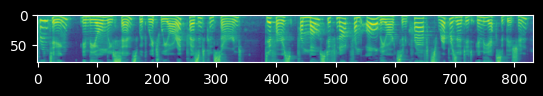

In [111]:
mel = get_mel('../datasets/LJSpeech-1.1/wavs/LJ001-0001.wav')
#print(mel)
#print(mel.shape)
plt.imshow(mel)
txt = get_text("Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition|Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition.")
#print(txt)
from torch.utils.data import DataLoader
from tacotron2.data_utils import TextMelLoader, TextMelCollate

hparams["batch_size"] = 1

trainset = TextMelLoader('../datasets/LJSpeech-1.1/metadata.csv', hparams)
collate_fn = TextMelCollate(hparams["n_frames_per_step"])

train_loader = DataLoader(trainset, num_workers=1, shuffle=False,
                            sampler=None,
                            batch_size=hparams["batch_size"], pin_memory=False,
                            drop_last=True, collate_fn=collate_fn)
#for i, b in enumerate(train_loader):
#    print(b)
#    break

#data = (txt, mel)
#x, y = model.parse_batch(b)
#y_pred = model(x)
#print(y)
#plot_data((y_pred[0].float().data.cpu().numpy()[0],
#           y_pred[1].float().data.cpu().numpy()[0],
#           y_pred[3].float().data.cpu().numpy()[0].T))
model.train()
from tacotron2.loss_function import Tacotron2Loss
criterion = Tacotron2Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                weight_decay=hparams["weight_decay"])

for i in range(5):
    loss = 0
    for i, b in enumerate(train_loader):
        x, y = model.parse_batch(b)
        y_pred = model(x)
        
        #plot_data((mel_outputs.float().data.cpu().numpy()[0],
        #        mel_outputs_postnet.float().data.cpu().numpy()[0],
        #        alignments.float().data.cpu().numpy()[0].T))

        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()
        break

In [ ]:

# step1 - converting a wav file to numpy array and then converting that to mel-spectrogram
my_audio_as_np_array, my_sample_rate= librosa.load("../alignment/aligned_post/bdl_arctic_a0001.wav")

# step2 - converting audio np array to spectrogram
spec = librosa.feature.melspectrogram(y=my_audio_as_np_array,
                                        sr=my_sample_rate, 
                                            n_fft=2048, 
                                            hop_length=512, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            pad_mode='reflect', 
                                            power=2.0,
                                     n_mels=80)
img = librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
print(spec.shape)
spec=spec[:,:35]
print(spec.shape)
#img = librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))
maxlen = 35
outlen = 140
from tacotron2.loss_function import Tacotron2Loss
criterion = Tacotron2Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                                 weight_decay=hparams["weight_decay"])

for i in range(300):
    mel_outputs, mel_outputs_postnet, _, alignments = model([processed.cuda(), lengths.cuda(), torch.tensor(spec).unsqueeze(0).cuda(), maxlen, lengths.cuda()])
    #out
    #plot_data((mel_outputs.float().data.cpu().numpy()[0],
    #        mel_outputs_postnet.float().data.cpu().numpy()[0],
    #        alignments.float().data.cpu().numpy()[0].T))

    y_pred = (mel_outputs, mel_outputs_postnet, _, alignments)
    loss = criterion(y_pred, torch.tensor(spec).cuda())
    print(loss)
    loss.backward()
    optimizer.step()

In [71]:
print(b)

(tensor([[57, 45, 46, 56, 11, 46, 56, 11, 38, 11, 41, 42, 43, 46, 51, 46, 57, 42,
         11, 38, 41, 59, 38, 51, 57, 38, 44, 42, 11, 57, 52, 11, 57, 45, 42, 11,
         56, 45, 52, 52, 57, 42, 55,  6, 11, 57, 45, 42, 11, 59, 42, 45, 46, 40,
         49, 42, 11, 50, 52, 59, 46, 51, 44, 11, 41, 46, 55, 42, 40, 57, 49, 62,
         11, 38, 60, 38, 62, 11, 43, 55, 52, 50, 11, 45, 46, 50, 11, 38, 51, 41,
         11, 57, 45, 42, 11, 41, 52, 60, 51, 44, 55, 38, 41, 42, 11, 52, 43, 11,
         57, 45, 42, 11, 56, 57, 55, 42, 42, 57,  6, 11, 38, 51, 41, 11, 45, 42,
         11, 39, 42, 46, 51, 44, 11, 46, 51, 11, 38, 51, 11, 42, 49, 42, 59, 38,
         57, 42, 41, 11, 53, 52, 56, 46, 57, 46, 52, 51]]), tensor([156]), tensor([[[-8.7789, -6.9985, -6.2513,  ..., -7.4818, -7.3807, -7.5928],
         [-8.1449, -6.6940, -5.8203,  ..., -7.2874, -7.1155, -6.6162],
         [-8.7240, -5.5389, -4.8171,  ..., -7.4338, -7.4879, -6.8355],
         ...,
         [-7.8394, -6.6874, -5.7064,  ..., -9.269

Warning! Reached max decoder steps


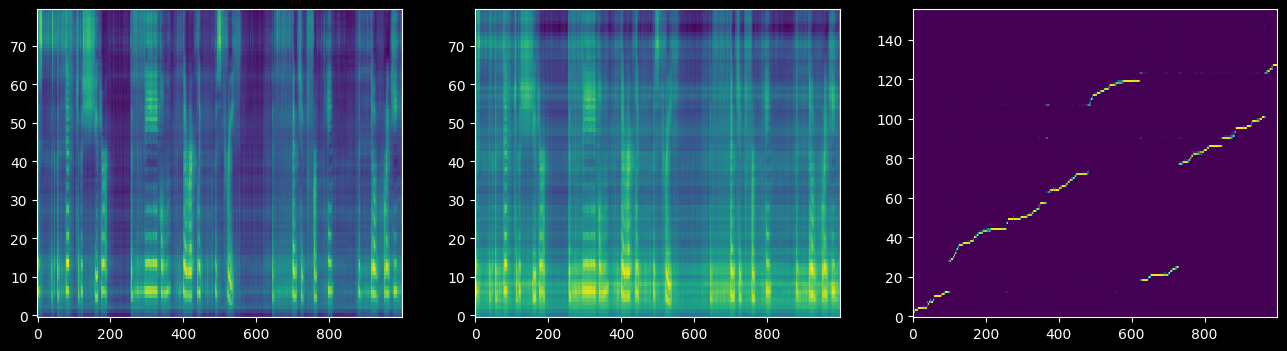

In [112]:
model.eval()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(b[0].cuda())
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [ ]:
librosa.display.specshow(librosa.power_to_db(spec, ref=np.max))

In [ ]:
librosa.display.specshow(librosa.power_to_db(out[1].detach().cpu()[0], ref=np.max))

#### Synthesize audio from spectrogram using WaveGlow

In [113]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
print(audio.shape)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams["sampling_rate"])

torch.Size([1, 256000])


#### (Optional) Remove WaveGlow bias

In [ ]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams["sampling_rate"]) 